In [92]:
#import packages and classes
import pandas as pd
import numpy as np
import cv2
from keras.utils.np_utils import to_categorical
from keras.layers import  MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
import pickle
import os
import matplotlib.pyplot as plt
import keras
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.applications import VGG16
from keras.applications import ResNet50
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Lambda, Activation, Flatten, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop, SGD
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from Attention import attention #===============importing attention layer
from sklearn.metrics import average_precision_score
import seaborn as sns
from numpy import dot
from numpy.linalg import norm

In [93]:
#function to normalize bounding boxes
def convert_bb(img, width, height, xmin, ymin, xmax, ymax):
    bb = []
    conv_x = (64. / width)
    conv_y = (64. / height)
    height = ymax * conv_y
    width = xmax * conv_x
    x = max(xmin * conv_x, 0)
    y = max(ymin * conv_y, 0)     
    x = x / 64
    y = y / 64
    width = width/64
    height = height/64
    return x, y, width, height

In [94]:
#define global variables to store processed images, labels and bounding boxes
boundings = []
X = []
Y = []

In [95]:
#define extended kalman filter object
kalman = cv2.TrackerKCF_create()

In [96]:
#define CVC-09 pedestrian dataset path
path = 'Dataset/Annotations'
if os.path.exists('model/X.txt.npy'):
    X = np.load('model/X.txt.npy')#load all processed images
    Y = np.load('model/Y.txt.npy')                    
    boundings = np.load('model/bb.txt.npy')#load bounding boxes
else:
    for root, dirs, directory in os.walk(path):#if not processed images then loop all annotation files with bounidng boxes
        for j in range(len(directory)):
            file = open('Dataset/Annotations/'+directory[j], 'r')
            name = directory[j]
            name = name.replace("txt","png")
            if os.path.exists("Dataset/FramesPos/"+name):
                img = cv2.imread("Dataset/FramesPos/"+name)
                height, width, channel = img.shape
                img = cv2.resize(img, (64, 64))#Resize image
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                lines = file.readlines()
                boxes = []
                for m in range(0,12):
                    boxes.append(0)
                start = 0    
                for i in range(len(lines)):#loop and read all bounding boxes from image
                    if start < 12:
                        line = lines[i].split(" ")
                        x1 = float(line[0])
                        y1 = float(line[1]) 
                        x2 = float(line[2])
                        y2 = float(line[3])
                        xx1 = x1 - x2 / 2
                        yy1 = y1 - y2 / 2
                        x2 = x1 + x2 / 2
                        y2 = y1 + y2 / 2
                        x1 = xx1
                        y1 = yy1
                        x1, y1, x2, y2 = convert_bb(img, width, height, x1, y1, x2, y2)#normalized bounding boxes
                        bbox = (x1 * 64, y1 * 64, x2 * 64, y2 * 64)
                        kalman.init(img, bbox)#apply kalman filter images to correct bounding box lovcations
                        kalman.update(img)
                        boxes[start] = x1
                        start += 1
                        boxes[start] = y1 
                        start += 1
                        boxes[start] = x2
                        start += 1
                        boxes[start] = y2
                        start += 1
                boundings.append(boxes)
                X.append(img)
                Y.append(0)
    X = np.asarray(X)#convert array to numpy format
    Y = np.asarray(Y)
    boundings = np.asarray(boundings)
    np.save('model/X.txt',X)#save all processed images
    np.save('model/Y.txt',Y)                    
    np.save('model/bb.txt',boundings)
print("Dataset Images Loaded")
print("Total Images Found in Dataset : "+str(X.shape[0]))

Dataset Images Loaded
Total Images Found in Dataset : 2199


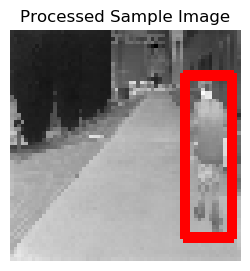

In [97]:
#plot sample image
sample = X[0] #get sample process image
bounding_box = boundings[0] #get bounding boxes
cv2.rectangle(sample, (int(bounding_box[0] * 64), int(bounding_box[1] * 64)), (int(bounding_box[2] * 64), int(bounding_box[3] * 64)), (255,0,0), 2, 1)
plt.figure(figsize =(3, 3)) 
plt.imshow(sample)#plot process image
plt.title('Processed Sample Image')
plt.axis('off')
plt.show()

In [98]:
#preprocess images by applying shuffling and then split dataset into train and test
indices = np.arange(X.shape[0])
np.random.shuffle(indices)#shuffle image pixels
X = X[indices]
Y = Y[indices]
boundings = boundings[indices]
#split dataset into train and test where 20% dataset size for testing and 80% for testing
split = train_test_split(X, Y, boundings, test_size=0.20, random_state=42)
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
print()
print("Dataset train & test split as 80% dataset for training and 20% for testing")
print("Training Size (80%): "+str(trainImages.shape[0])) #print training and test size
print("Testing Size (20%): "+str(testImages.shape[0]))
print()


Dataset train & test split as 80% dataset for training and 20% for testing
Training Size (80%): 1759
Testing Size (20%): 440



In [99]:
#define global variables to calculate and store accuracy and other metrics
precision = []
recall = []
fscore = []
accuracy = []


In [100]:
#function to calculate various metrics such as accuracy, precision etc
def calculateMetrics(algorithm, predict, testY):
    p = precision_score(testY, predict,average='micro') * 100
    r = recall_score(testY, predict,average='micro') * 100
    f = f1_score(testY, predict,average='micro') * 100
    a = accuracy_score(testY,predict)*100     
    print(algorithm+' Accuracy  : '+str(a))
    print(algorithm+' Precision : '+str(p))
    print(algorithm+' Recall    : '+str(r))
    print(algorithm+' FSCORE    : '+str(f))    
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    
    

In [101]:
#train existing FRCNN algorithm without using squeeze attention model
def FRCNN():
    if os.path.exists("model/frcnn.hdf5") == False:
        rcnn = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(X.shape[1], X.shape[2], X.shape[3])))
        rcnn.trainable = False
        flatten = rcnn.output
        flatten = Flatten()(flatten)
        bboxHead = Dense(16, activation="relu")(flatten)
        bboxHead = Dense(8, activation="relu")(bboxHead)
        bboxHead = Dense(8, activation="relu")(bboxHead)
        bboxHead = Dense(12, activation="sigmoid", name="bounding_box")(bboxHead)
        softmaxHead = Dense(16, activation="relu")(flatten)
        softmaxHead = Dropout(0.2)(softmaxHead)
        softmaxHead = Dense(8, activation="relu")(softmaxHead)
        softmaxHead = Dropout(0.2)(softmaxHead)
        softmaxHead = Dense(1, activation="softmax", name="class_label")(softmaxHead)
        frcnn_model = Model(inputs=rcnn.input, outputs=(bboxHead, softmaxHead))
        losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}
        lossWeights = {"class_label": 1.0, "bounding_box": 1.0}
        opt = Adam(lr=1e-4)
        frcnn_model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
        trainTargets = {"class_label": trainLabels, "bounding_box": trainBBoxes}
        testTargets = {"class_label": testLabels, "bounding_box": testBBoxes}
        model_check_point = ModelCheckpoint(filepath='model/frcnn.hdf5', verbose = 1, save_best_only = True)
        hist = frcnn_model.fit(trainImages, trainTargets, validation_data=(testImages, testTargets), batch_size=32, epochs=10, verbose=1,callbacks=[model_check_point])
        f = open('model/frcnn.pckl', 'wb')
        pickle.dump(hist.history, f)
        f.close()
    else:
        frcnn_model = load_model('model/frcnn.hdf5')
    predict = frcnn_model.predict(testImages)[0]#perform prediction on test data
    pred = []
    for i in range(len(predict)):
        box_acc = dot(predict[i], testBBoxes[i])/(norm(predict[i])*norm(testBBoxes[i]))
        if box_acc < 0.56:
            pred.append(1)
        else:
            pred.append(0)
    calculateMetrics("Faster RCNN", pred, testLabels)#call this function to calculate accuracy and other metrics       
FRCNN()  

Faster RCNN Accuracy  : 81.81818181818183
Faster RCNN Precision : 81.81818181818183
Faster RCNN Recall    : 81.81818181818183
Faster RCNN FSCORE    : 81.81818181818183


In [102]:
#train propose improved YoloV5 with squeeze attention model
#define input shape
input_img = Input(shape=(64, 64, 3))
#create YoloV4 layers with 32, 64 and 512 neurons or data filteration size
x = Conv2D(32, (3, 3), padding = 'same', activation = 'relu')(input_img)
x = Conv2D(32, (3, 3), padding = 'same', activation = 'relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(x)
x = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(x)
x = MaxPooling2D((2, 2))(x)
x = attention(return_sequences=True,name='attention')(x)====#adding squeeze attention model to make improved Yolov5
x = Flatten()(x)
#define output layer with 4 bounding box coordinate and 1 weapan class
x = Dense(256, activation = 'relu')(x)
x = Dense(256, activation = 'relu')(x)
x_bb = Dense(12, name='bb',activation='sigmoid')(x)
x_class = Dense(1, activation='sigmoid', name='class')(x)
#create yolo Model with above input details
yolo_model = Model([input_img], [x_bb, x_class])
#compile the model
yolo_model.compile(Adam(lr=0.0001), loss=['mse', 'binary_crossentropy'], metrics=['accuracy'])
if os.path.exists("model/yolo_weights.hdf5") == False:#if model not trained then train the model
    model_check_point = ModelCheckpoint(filepath='model/yolo_weights.hdf5', verbose = 1, save_best_only = True)
    hist = yolo_model.fit(trainImages, [trainBBoxes, trainLabels], batch_size=32, epochs=10, validation_data=(testImages, [testBBoxes, testLabels]), callbacks=[model_check_point])
    f = open('model/yolo_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:#if model already trained then load it
    yolo_model = load_model("model/yolo_weights.hdf5", custom_objects={'attention': attention})
predict = yolo_model.predict(testImages)#perform prediction on test data
predict = predict[0]
pred = []
for i in range(len(predict)):
    box_acc = dot(predict[i], testBBoxes[i])/(norm(predict[i])*norm(testBBoxes[i]))
    if box_acc < 0.80:
        pred.append(1)
    else:
        pred.append(0)
calculateMetrics("Propose Improved YoloV5", pred, testLabels)#call this function to calculate accuracy and other metrics           

Propose Improved YoloV5 Accuracy  : 95.0
Propose Improved YoloV5 Precision : 95.0
Propose Improved YoloV5 Recall    : 95.0
Propose Improved YoloV5 FSCORE    : 95.0


In [103]:
#train extension Yolov6 model which is advance version of YoloV5
def runYolov6():
    if os.path.exists("model/yolov6.hdf5") == False:
        yolov6 = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(X.shape[1], X.shape[2], X.shape[3])))
        yolov6.trainable = False
        flatten = yolov6.output
        flatten = Flatten()(flatten)
        bboxHead = Dense(16, activation="relu")(flatten)
        bboxHead = Dense(8, activation="relu")(bboxHead)
        bboxHead = Dense(8, activation="relu")(bboxHead)
        bboxHead = Dense(12, activation="sigmoid", name="bounding_box")(bboxHead)
        softmaxHead = Dense(16, activation="relu")(flatten)
        softmaxHead = Dropout(0.2)(softmaxHead)
        softmaxHead = Dense(8, activation="relu")(softmaxHead)
        softmaxHead = Dropout(0.2)(softmaxHead)
        softmaxHead = Dense(1, activation="sigmoid", name="class_label")(softmaxHead)
        yolov6_model = Model(inputs=yolov6.input, outputs=(bboxHead, softmaxHead))
        losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}
        lossWeights = {"class_label": 1.0, "bounding_box": 1.0}
        opt = Adam(lr=1e-4)
        yolov6_model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
        trainTargets = {"class_label": trainLabels, "bounding_box": trainBBoxes}
        testTargets = {"class_label": testLabels, "bounding_box": testBBoxes}
        model_check_point = ModelCheckpoint(filepath='model/yolov6.hdf5', verbose = 1, save_best_only = True)
        hist = yolov6_model.fit(trainImages, trainTargets, validation_data=(testImages, testTargets), batch_size=32, epochs=10, verbose=1,callbacks=[model_check_point])
        f = open('model/yolov6.pckl', 'wb')
        pickle.dump(hist.history, f)
        f.close()
    else:
        yolov6_model = load_model('model/yolov6.hdf5')
    predict = yolov6_model.predict(testImages)[0]#perform prediction on test data
    pred = []
    for i in range(len(predict)):
        box_acc = dot(predict[i], testBBoxes[i])/(norm(predict[i])*norm(testBBoxes[i]))
        if box_acc < 0.57:
            pred.append(1)
        else:
            pred.append(0)
    calculateMetrics("Extension YoloV6", pred, testLabels)#call this function to calculate accuracy and other metrics    
runYolov6()

Extension YoloV6 Accuracy  : 98.86363636363636
Extension YoloV6 Precision : 98.86363636363636
Extension YoloV6 Recall    : 98.86363636363636
Extension YoloV6 FSCORE    : 98.86363636363636


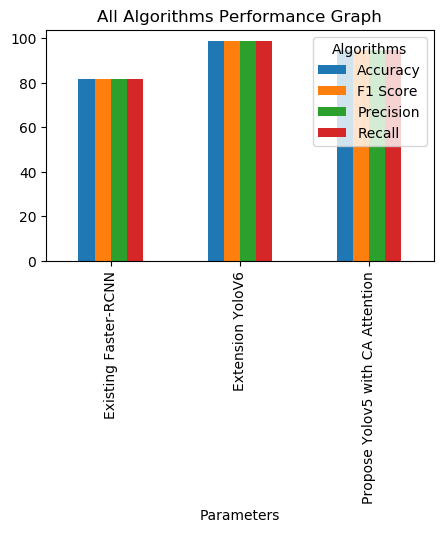

In [104]:
#all algorithm Perfromnace Graph
df = pd.DataFrame([['Existing Faster-RCNN','Precision',precision[0]],['Existing Faster-RCNN','Recall',recall[0]],['Existing Faster-RCNN','F1 Score',fscore[0]],['Existing Faster-RCNN','Accuracy',accuracy[0]],
                   ['Propose Yolov5 with CA Attention','Precision',precision[1]],['Propose Yolov5 with CA Attention','Recall',recall[1]],['Propose Yolov5 with CA Attention','F1 Score',fscore[1]],['Propose Yolov5 with CA Attention','Accuracy',accuracy[1]],
                   ['Extension YoloV6','Precision',precision[2]],['Extension YoloV6','Recall',recall[2]],['Extension YoloV6','F1 Score',fscore[2]],['Extension YoloV6','Accuracy',accuracy[2]],
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot("Parameters", "Algorithms", "Value").plot(kind='bar', figsize =(5, 3))
plt.title("All Algorithms Performance Graph")
plt.show()

In [105]:
#showing all algorithms with scenario A and B performance values
columns = ["Algorithm Name","Precison","Recall","FScore","Accuracy"]
values = []
algorithm_names = ["Existing Faster-RCNN","Propose YoloV5 with CA Attention", "Extension YoloV6"]
for i in range(len(algorithm_names)):
    values.append([algorithm_names[i],precision[i],recall[i],fscore[i],accuracy[i]])    
temp = pd.DataFrame(values,columns=columns)
temp

,Algorithm Name,Precison,Recall,FScore,Accuracy
0,Existing Faster-RCNN,81.818182,81.818182,81.818182,81.818182
1,Propose YoloV5 with CA Attention,95.000000,95.000000,95.000000,95.000000
2,Extension YoloV6,98.863636,98.863636,98.863636,98.863636


In [106]:
def values(filename, acc, loss):
    f = open(filename, 'rb')
    train_values = pickle.load(f)
    f.close()
    accuracy_value = train_values[acc]
    loss_value = train_values[loss]
    return accuracy_value, loss_value

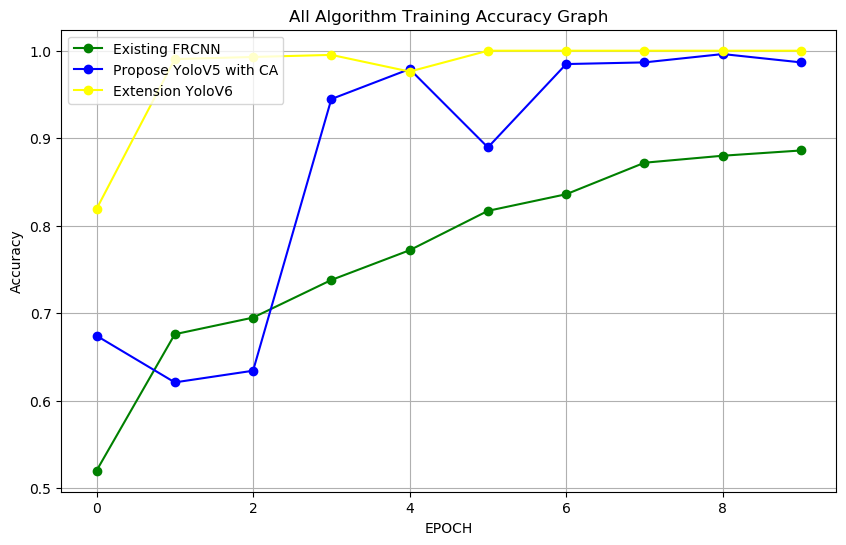

In [107]:
frcnn_acc, frcnn_loss = values("model/frcnn_history.pckl", "accuracy", "loss")
propose_acc, propose_loss = values("model/yolo_history.pckl", "val_class_label_accuracy", "val_loss")
extension_acc, extension_loss = values("model/yolov6.pckl", "val_class_accuracy", "val_loss")
    
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('EPOCH')
plt.ylabel('Accuracy')
plt.plot(frcnn_acc, 'ro-', color = 'green')
plt.plot(propose_acc, 'ro-', color = 'blue')
plt.plot(extension_acc, 'ro-', color = 'yellow')
plt.legend(['Existing FRCNN', 'Propose YoloV5 with CA','Extension YoloV6'], loc='upper left')
plt.title('All Algorithm Training Accuracy Graph')
plt.show()

In [108]:
#function to detect and predict pedestrains
def predictPedestrian(image_path):
    img = cv2.imread(image_path)#read test image
    img = cv2.resize(img, (64, 64))#Resize image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img1 = img.reshape(1,64,64,3)
    predict_value = yolo_model.predict(img1)#perform prediction on test data using extension model
    predict = predict_value[0]#get bounding boxes
    predict = predict[0]
    predicted_label = predict_value[1][0][0] #get predicted label
    flag = True
    start = 0
    while flag:#now loop and plot all detected pedestrains
        if start < 12:
            x1 = predict[start] * 64
            start += 1
            y1 = predict[start] * 64
            start += 1
            x2 = predict[start] * 64
            start += 1
            y2 = predict[start] * 64
            start += 1
            if x1 > 0 and y1 > 0 and x2 > 0 and y2 > 20:
                cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (255,0,0), 1, 1)
                cv2.putText(img, str(int(predicted_label)+1), (int(x1), int(y1+40)),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (0, 0, 255), 2)            
        else:
            flag = False
    plt.figure(figsize =(3, 3)) 
    plt.imshow(img)#plot process image
    plt.title('Predicted Output')
    plt.axis('off')
    plt.show()                

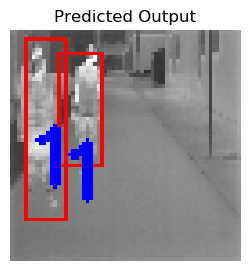

In [109]:
#call this function to detect pedestrians
predictPedestrian("testImages/4.png")

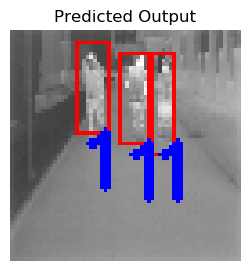

In [110]:
#call this function to detect pedestrians
predictPedestrian("testImages/5.png")

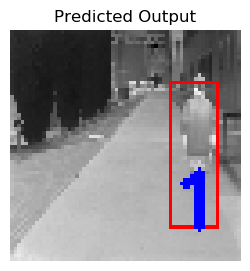

In [111]:
#call this function to detect pedestrians
predictPedestrian("testImages/2.png")

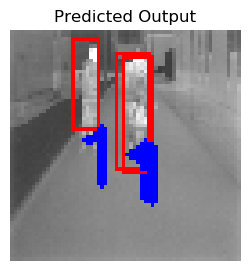

In [112]:
#call this function to detect pedestrians
predictPedestrian("testImages/3.png")